# Ablation Study Analysis

This notebook generates horizontal bar charts comparing ablations against a baseline:
- Success Rate Change (%)
- Break Rate Change (%)
- Error bars showing standard deviation across seeds

In [2]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Base method (full method that ablations are compared against)
BASE_CONFIG = {
    "key": "full",
    "display_name": "Full Method",
    "tag": "LCLoP_perf-comp:2026-01-05_10:54",
}

# Ablations - list of configurations to compare against base
# Each entry: {"key": internal_key, "display_name": name_for_plot, "tag": wandb_tag}
ABLATIONS = [
    {"key": "no_zCon", "display_name": "No Z-Contact Reward", "tag": "ablate_no-z-contact:2026-01-05_10:54"},
    {"key": "no_ssl", "display_name": "No Supervised Selection Loss", "tag": "ablate_no-SSL:2026-01-05_10:54"},
    {"key": "ff", "display_name": "Perfect Selection", "tag": "ablate_ff:2026-01-05_10:54"},
    {"key": "bias_25", "display_name": "Bias 25% Force", "tag": "ablate_bias-25:2026-01-05_10:54"},
    {"key": "bias_50", "display_name": "No Bias", "tag": "ablate_bias-50:2026-01-05_10:54"},
    {"key": "bias_75", "display_name": "Bias 75% Force", "tag": "ablate_bias-75:2026-01-05_10:54"},
    {"key": "bias_93", "display_name": "Bias 93% Force", "tag": "ablate_bias-93:2026-01-05_10:54"},
]

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"

# Metrics
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"
METRIC_TOTAL = "total_episodes"

In [3]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """Find the best checkpoint for each run with the given method tag."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    best_checkpoints = {}
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        best_checkpoints[run.id] = {
            "run_name": run.name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
        }
        print(f"    {run.name}: best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for base and all ablations
api = wandb.Api()
best_checkpoints = {}  # best_checkpoints[key]

# Base method
print(f"\n{'='*60}")
print(f"Base: {BASE_CONFIG['display_name']} ({BASE_CONFIG['tag']})")
print(f"{'='*60}")
best_checkpoints[BASE_CONFIG["key"]] = get_best_checkpoint_per_run(api, BASE_CONFIG["tag"])

# Ablations
for ablation in ABLATIONS:
    print(f"\n{'='*60}")
    print(f"Ablation: {ablation['display_name']} ({ablation['tag']})")
    print(f"{'='*60}")
    best_checkpoints[ablation["key"]] = get_best_checkpoint_per_run(api, ablation["tag"])

wandb: Currently logged in as: robonuke (hur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Base: Full Method (LCLoP_perf-comp:2026-01-05_10:54)
    Eval_performance_LCLoP_perf-comp_f(10)_0: best checkpoint at step 1689600 (score: 99)
    Eval_performance_LCLoP_perf-comp_f(10)_1: best checkpoint at step 2457600 (score: 88)
    Eval_performance_LCLoP_perf-comp_f(10)_2: best checkpoint at step 2380800 (score: 91)
    Eval_performance_LCLoP_perf-comp_f(10)_3: best checkpoint at step 2880000 (score: 94)
    Eval_performance_LCLoP_perf-comp_f(10)_4: best checkpoint at step 1612800 (score: 99)

Ablation: No Z-Contact Reward (ablate_no-z-contact:2026-01-05_10:54)
    Eval_performance_ablate_no-z-contact_f(10)_0: best checkpoint at step 1843200 (score: 95)
    Eval_performance_ablate_no-z-contact_f(10)_2: best checkpoint at step 1996800 (score: 96)
    Eval_performance_ablate_no-z-contact_f(10)_1: best checkpoint at step 2342400 (score: 99)
    Eval_performance_ablate_no-z-contact_f(10)_3: best checkpoint at step 2227200 (score: 98)
    Eval_performance_ablate_no-z-contact_f(10)_4: 

In [4]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

def download_eval_performance_data(api, method_tag, best_checkpoints):
    """Download eval_performance data for best checkpoints."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    data = []
    for run in runs:
        if run.id not in best_checkpoints:
            continue
        
        best_step = best_checkpoints[run.id]["best_step"]
        history = run.history()
        
        if best_step not in history["total_steps"].values:
            print(f"Warning: Checkpoint {best_step} not found in {run.name}")
            continue
            
        row = history[history["total_steps"] == best_step].iloc[0]
        
        data.append({
            "run_id": run.id,
            "run_name": run.name,
            "checkpoint": best_step,
            "success": row[f"Eval_Core/{METRIC_SUCCESS}"],
            "breaks": row[f"Eval_Core/{METRIC_BREAKS}"],
            "total": row[f"Eval_Core/{METRIC_TOTAL}"],
        })
    
    return pd.DataFrame(data)

# Download all data
perf_data = {}  # perf_data[key]

# Base method
print(f"\nDownloading data for Base: {BASE_CONFIG['display_name']}...")
perf_data[BASE_CONFIG["key"]] = download_eval_performance_data(
    api, BASE_CONFIG["tag"], best_checkpoints[BASE_CONFIG["key"]]
)

# Ablations
for ablation in ABLATIONS:
    print(f"Downloading data for Ablation: {ablation['display_name']}...")
    perf_data[ablation["key"]] = download_eval_performance_data(
        api, ablation["tag"], best_checkpoints[ablation["key"]]
    )

# Compute statistics for each configuration
stats = {}  # stats[key] = {"success_mean", "success_std", "break_mean", "break_std"}

for key, df in perf_data.items():
    if df.empty:
        stats[key] = {
            "success_mean": 0, "success_std": 0,
            "break_mean": 0, "break_std": 0,
            "n_runs": 0
        }
        continue
    
    # Calculate per-run rates
    df = df.copy()
    df["success_rate"] = 100 * df["success"] / df["total"]
    df["break_rate"] = 100 * df["breaks"] / df["total"]
    
    stats[key] = {
        "success_mean": df["success_rate"].mean(),
        "success_std": df["success_rate"].std(),
        "break_mean": df["break_rate"].mean(),
        "break_std": df["break_rate"].std(),
        "n_runs": len(df)
    }

# Print summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
print(f"\nBase - {BASE_CONFIG['display_name']}:")
s = stats[BASE_CONFIG["key"]]
print(f"  Runs: {s['n_runs']}")
print(f"  Success: {s['success_mean']:.1f}% +/- {s['success_std']:.1f}%")
print(f"  Break: {s['break_mean']:.1f}% +/- {s['break_std']:.1f}%")

for ablation in ABLATIONS:
    s = stats[ablation["key"]]
    print(f"\n{ablation['display_name']}:")
    print(f"  Runs: {s['n_runs']}")
    print(f"  Success: {s['success_mean']:.1f}% +/- {s['success_std']:.1f}%")
    print(f"  Break: {s['break_mean']:.1f}% +/- {s['break_std']:.1f}%")



DATA SUMMARY

Base - Full Method:
  Runs: 5
  Success: 96.0% +/- 3.1%
  Break: 1.8% +/- 1.8%

No Z-Contact Reward:
  Runs: 5
  Success: 98.2% +/- 1.3%
  Break: 0.6% +/- 0.9%

No Supervised Selection Loss:
  Runs: 5
  Success: 81.0% +/- 2.8%
  Break: 11.4% +/- 4.0%

Perfect Selection:
  Runs: 5
  Success: 96.0% +/- 3.1%
  Break: 2.8% +/- 3.0%

Bias 25% Force:
  Runs: 5
  Success: 93.4% +/- 6.4%
  Break: 2.2% +/- 3.3%

No Bias:
  Runs: 5
  Success: 77.4% +/- 43.3%
  Break: 0.4% +/- 0.5%

Bias 75% Force:
  Runs: 5
  Success: 95.8% +/- 4.6%
  Break: 0.6% +/- 0.9%

Bias 93% Force:
  Runs: 5
  Success: 89.2% +/- 15.8%
  Break: 2.2% +/- 1.6%


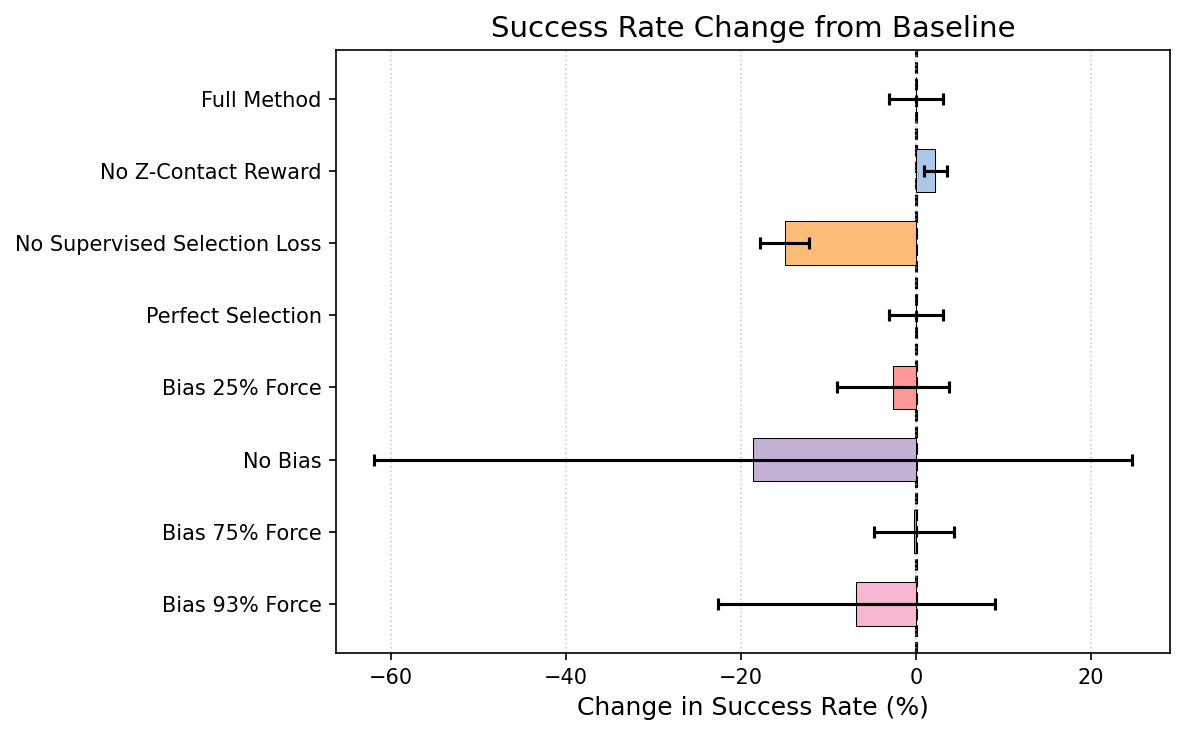

In [5]:
# ============================================================
# BLOCK 4: SUCCESS RATE ABLATION PLOT
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Figure Configuration
FIGSIZE = (8, 5)
DPI = 150
BAR_HEIGHT = 0.6

# Colors - one per configuration (base + ablations)
# Will be assigned in order: base first, then ablations
BAR_COLORS = [
    "#1f77b4",  # Blue (base)
    "#aec7e8",  # Light blue
    "#ffbb78",  # Light orange
    "#98df8a",  # Light green
    "#ff9896",  # Light red
    "#c5b0d5",  # Light purple
    "#c49c94",  # Light brown
    "#f7b6d2",  # Light pink
]

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 12
FONT_TICK = 10

# Error bar configuration
ERROR_BAR_COLOR = "black"
ERROR_BAR_CAPSIZE = 3
ERROR_BAR_LINEWIDTH = 1.5

# Baseline reference line
BASELINE_COLOR = "black"
BASELINE_LINEWIDTH = 1.5
BASELINE_LINESTYLE = "--"

# Labels
TITLE = "Success Rate Change from Baseline"
X_LABEL = "Change in Success Rate (%)"

# ============================================================

def filter_top_n_stats(perf_data, best_checkpoints, key, top_n):
    """Recompute stats for top N runs only."""
    df = perf_data[key]
    if df.empty or top_n is None or len(best_checkpoints[key]) <= top_n:
        return stats[key]
    
    # Get top N run IDs by score
    sorted_runs = sorted(best_checkpoints[key].items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_ids = {run_id for run_id, _ in sorted_runs[:top_n]}
    
    df_filtered = df[df["run_id"].isin(top_run_ids)].copy()
    df_filtered["success_rate"] = 100 * df_filtered["success"] / df_filtered["total"]
    df_filtered["break_rate"] = 100 * df_filtered["breaks"] / df_filtered["total"]
    
    return {
        "success_mean": df_filtered["success_rate"].mean(),
        "success_std": df_filtered["success_rate"].std(),
        "break_mean": df_filtered["break_rate"].mean(),
        "break_std": df_filtered["break_rate"].std(),
        "n_runs": len(df_filtered)
    }

# Build list of all configs (base first, then ablations)
all_configs = [BASE_CONFIG] + ABLATIONS

# Compute filtered stats if needed
filtered_stats = {}
for config in all_configs:
    filtered_stats[config["key"]] = filter_top_n_stats(
        perf_data, best_checkpoints, config["key"], TOP_N_POLICIES
    )

# Get baseline success rate
base_success = filtered_stats[BASE_CONFIG["key"]]["success_mean"]

# Compute percentage change from baseline for each config
display_names = []
changes = []
errors = []
colors = []

for i, config in enumerate(all_configs):
    s = filtered_stats[config["key"]]
    change = s["success_mean"] - base_success  # Percentage point change
    
    display_names.append(config["display_name"])
    changes.append(change)
    errors.append(s["success_std"])
    colors.append(BAR_COLORS[i % len(BAR_COLORS)])

# Reverse order so base is at top
display_names = display_names[::-1]
changes = changes[::-1]
errors = errors[::-1]
colors = colors[::-1]

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

y_pos = np.arange(len(display_names))

# Draw horizontal bars
bars = ax.barh(y_pos, changes, height=BAR_HEIGHT, color=colors, edgecolor='black', linewidth=0.5)

# Add error bars
ax.errorbar(changes, y_pos, xerr=errors, fmt='none', 
            color=ERROR_BAR_COLOR, capsize=ERROR_BAR_CAPSIZE, 
            linewidth=ERROR_BAR_LINEWIDTH, capthick=ERROR_BAR_LINEWIDTH)

# Add vertical line at 0 (baseline)
ax.axvline(x=0, color=BASELINE_COLOR, linewidth=BASELINE_LINEWIDTH, 
           linestyle=BASELINE_LINESTYLE, zorder=0)

# Configure axes
ax.set_yticks(y_pos)
ax.set_yticklabels(display_names, fontsize=FONT_TICK)
ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE, fontsize=FONT_TITLE)
ax.tick_params(axis='x', labelsize=FONT_TICK)

# Add grid for readability
ax.xaxis.grid(True, linestyle=':', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

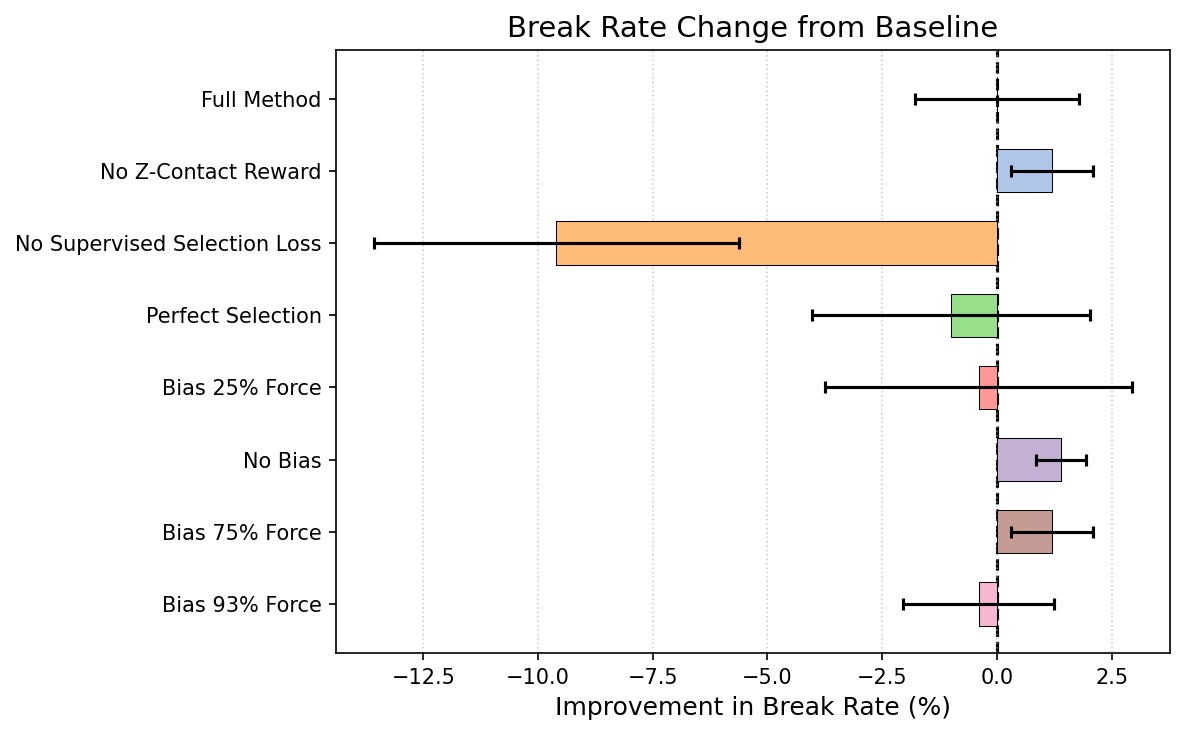

In [6]:
# ============================================================
# BLOCK 5: BREAK RATE ABLATION PLOT
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Break rate direction: if True, lower break rate = positive change (improvement)
# if False, raw direction (lower break rate = negative change)
LOWER_IS_BETTER = True

# Figure Configuration
FIGSIZE = (8, 5)
DPI = 150
BAR_HEIGHT = 0.6

# Colors - one per configuration (base + ablations)
BAR_COLORS = [
    "#1f77b4",  # Blue (base)
    "#aec7e8",  # Light blue
    "#ffbb78",  # Light orange
    "#98df8a",  # Light green
    "#ff9896",  # Light red
    "#c5b0d5",  # Light purple
    "#c49c94",  # Light brown
    "#f7b6d2",  # Light pink
]

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 12
FONT_TICK = 10

# Error bar configuration
ERROR_BAR_COLOR = "black"
ERROR_BAR_CAPSIZE = 3
ERROR_BAR_LINEWIDTH = 1.5

# Baseline reference line
BASELINE_COLOR = "black"
BASELINE_LINEWIDTH = 1.5
BASELINE_LINESTYLE = "--"

# Labels
TITLE = "Break Rate Change from Baseline"
X_LABEL_LOWER_BETTER = "Improvement in Break Rate (%)"  # When LOWER_IS_BETTER=True
X_LABEL_RAW = "Change in Break Rate (%)"  # When LOWER_IS_BETTER=False

# ============================================================

def filter_top_n_stats(perf_data, best_checkpoints, key, top_n):
    """Recompute stats for top N runs only."""
    df = perf_data[key]
    if df.empty or top_n is None or len(best_checkpoints[key]) <= top_n:
        return stats[key]
    
    # Get top N run IDs by score
    sorted_runs = sorted(best_checkpoints[key].items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_ids = {run_id for run_id, _ in sorted_runs[:top_n]}
    
    df_filtered = df[df["run_id"].isin(top_run_ids)].copy()
    df_filtered["success_rate"] = 100 * df_filtered["success"] / df_filtered["total"]
    df_filtered["break_rate"] = 100 * df_filtered["breaks"] / df_filtered["total"]
    
    return {
        "success_mean": df_filtered["success_rate"].mean(),
        "success_std": df_filtered["success_rate"].std(),
        "break_mean": df_filtered["break_rate"].mean(),
        "break_std": df_filtered["break_rate"].std(),
        "n_runs": len(df_filtered)
    }

# Build list of all configs (base first, then ablations)
all_configs = [BASE_CONFIG] + ABLATIONS

# Compute filtered stats if needed
filtered_stats = {}
for config in all_configs:
    filtered_stats[config["key"]] = filter_top_n_stats(
        perf_data, best_checkpoints, config["key"], TOP_N_POLICIES
    )

# Get baseline break rate
base_break = filtered_stats[BASE_CONFIG["key"]]["break_mean"]

# Compute percentage change from baseline for each config
display_names = []
changes = []
errors = []
colors = []

for i, config in enumerate(all_configs):
    s = filtered_stats[config["key"]]
    
    if LOWER_IS_BETTER:
        # Invert so that lower break rate = positive (improvement)
        change = base_break - s["break_mean"]
    else:
        # Raw direction: lower break rate = negative change
        change = s["break_mean"] - base_break
    
    display_names.append(config["display_name"])
    changes.append(change)
    errors.append(s["break_std"])
    colors.append(BAR_COLORS[i % len(BAR_COLORS)])

# Reverse order so base is at top
display_names = display_names[::-1]
changes = changes[::-1]
errors = errors[::-1]
colors = colors[::-1]

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

y_pos = np.arange(len(display_names))

# Draw horizontal bars
bars = ax.barh(y_pos, changes, height=BAR_HEIGHT, color=colors, edgecolor='black', linewidth=0.5)

# Add error bars
ax.errorbar(changes, y_pos, xerr=errors, fmt='none', 
            color=ERROR_BAR_COLOR, capsize=ERROR_BAR_CAPSIZE, 
            linewidth=ERROR_BAR_LINEWIDTH, capthick=ERROR_BAR_LINEWIDTH)

# Add vertical line at 0 (baseline)
ax.axvline(x=0, color=BASELINE_COLOR, linewidth=BASELINE_LINEWIDTH, 
           linestyle=BASELINE_LINESTYLE, zorder=0)

# Configure axes
ax.set_yticks(y_pos)
ax.set_yticklabels(display_names, fontsize=FONT_TICK)
ax.set_xlabel(X_LABEL_LOWER_BETTER if LOWER_IS_BETTER else X_LABEL_RAW, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE, fontsize=FONT_TITLE)
ax.tick_params(axis='x', labelsize=FONT_TICK)

# Add grid for readability
ax.xaxis.grid(True, linestyle=':', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [7]:
# ============================================================
# BLOCK 6: LATEX TABLE - ABLATION RESULTS
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Table Configuration
TABLE_CAPTION = "Ablation study results. Best performance per metric in \\textbf{bold}."
TABLE_LABEL = "tab:ablation"

# Column formatting
DECIMAL_PLACES = 1

# ============================================================

def filter_top_n_stats(perf_data, best_checkpoints, key, top_n):
    """Recompute stats for top N runs only."""
    df = perf_data[key]
    if df.empty or top_n is None or len(best_checkpoints[key]) <= top_n:
        return stats[key]
    
    sorted_runs = sorted(best_checkpoints[key].items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_ids = {run_id for run_id, _ in sorted_runs[:top_n]}
    
    df_filtered = df[df["run_id"].isin(top_run_ids)].copy()
    df_filtered["success_rate"] = 100 * df_filtered["success"] / df_filtered["total"]
    df_filtered["break_rate"] = 100 * df_filtered["breaks"] / df_filtered["total"]
    
    return {
        "success_mean": df_filtered["success_rate"].mean(),
        "success_std": df_filtered["success_rate"].std(),
        "break_mean": df_filtered["break_rate"].mean(),
        "break_std": df_filtered["break_rate"].std(),
        "n_runs": len(df_filtered)
    }

def format_mean_std(mean, std, decimal=1):
    return f"{mean:.{decimal}f} $\\pm$ {std:.{decimal}f}"

def bold_if_best(value_str, is_best):
    if is_best:
        return f"\\textbf{{{value_str}}}"
    return value_str

# Build list of all configs (base first, then ablations)
all_configs = [BASE_CONFIG] + ABLATIONS

# Compute filtered stats if needed
filtered_stats = {}
for config in all_configs:
    filtered_stats[config["key"]] = filter_top_n_stats(
        perf_data, best_checkpoints, config["key"], TOP_N_POLICIES
    )

# Find best values
best_success = max(filtered_stats[c["key"]]["success_mean"] for c in all_configs)
best_break = min(filtered_stats[c["key"]]["break_mean"] for c in all_configs)

# Generate LaTeX
UP_ARROW = "$\\uparrow$"
DOWN_ARROW = "$\\downarrow$"

latex_lines = [
    "\\begin{table}[t]",
    "\\centering",
    f"\\caption{{{TABLE_CAPTION}}}",
    f"\\label{{{TABLE_LABEL}}}",
    "\\begin{tabular}{lcc}",
    "\\toprule",
    f"Configuration & Success {UP_ARROW} & Break {DOWN_ARROW} \\\\",
    "\\midrule",
]

for config in all_configs:
    s = filtered_stats[config["key"]]
    
    success_str = format_mean_std(s["success_mean"], s["success_std"], DECIMAL_PLACES)
    break_str = format_mean_std(s["break_mean"], s["break_std"], DECIMAL_PLACES)
    
    is_best_success = abs(s["success_mean"] - best_success) < 0.01
    is_best_break = abs(s["break_mean"] - best_break) < 0.01
    
    success_str = bold_if_best(success_str, is_best_success)
    break_str = bold_if_best(break_str, is_best_break)
    
    latex_lines.append(f"{config['display_name']} & {success_str} & {break_str} \\\\")

latex_lines.extend([
    "\\bottomrule",
    "\\end{tabular}",
    "\\end{table}",
])

latex_output = "\n".join(latex_lines)
print(latex_output)

\begin{table}[t]
\centering
\caption{Ablation study results. Best performance per metric in \textbf{bold}.}
\label{tab:ablation}
\begin{tabular}{lcc}
\toprule
Configuration & Success $\uparrow$ & Break $\downarrow$ \\
\midrule
Full Method & 96.0 $\pm$ 3.1 & 1.8 $\pm$ 1.8 \\
No Z-Contact Reward & \textbf{98.2 $\pm$ 1.3} & 0.6 $\pm$ 0.9 \\
No Supervised Selection Loss & 81.0 $\pm$ 2.8 & 11.4 $\pm$ 4.0 \\
Perfect Selection & 96.0 $\pm$ 3.1 & 2.8 $\pm$ 3.0 \\
Bias 25% Force & 93.4 $\pm$ 6.4 & 2.2 $\pm$ 3.3 \\
No Bias & 77.4 $\pm$ 43.3 & \textbf{0.4 $\pm$ 0.5} \\
Bias 75% Force & 95.8 $\pm$ 4.6 & 0.6 $\pm$ 0.9 \\
Bias 93% Force & 89.2 $\pm$ 15.8 & 2.2 $\pm$ 1.6 \\
\bottomrule
\end{tabular}
\end{table}
